# Лабораторная работа №3. Рекуррентные нейронные сети и задачи обработки последовательностей.
Обработка временных данных и обучение регрессии.
New York Stock Exchange (NYSE) dataset, RNN-LSTM model.

# Загрузка и анализ данных.

In [ ]:
! pip install -q kaggle

In [1]:
# Установка датасета.
import sys
import os


CWD = os.getcwd()
BASE_PATH = '/content/nyse'
if 'google.colab' in sys.modules:
    print('Running on Google Colab')
    ! kaggle datasets download -d dgawlik/nyse
    ! unzip '/content/nyse.zip' -d '/content/nyse'
else:
    import zipfile
    
    print('Running on Local Environment')
    ! kaggle datasets download -d dgawlik/nyse -p ./content
    
    zip_path = os.path.join(CWD, 'content', 'nyse.zip')
    unzip_path = os.path.join(CWD, 'content', 'nyse')
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(unzip_path)

    BASE_PATH = CWD + BASE_PATH

Running on Local Environment
Dataset URL: https://www.kaggle.com/datasets/dgawlik/nyse
License(s): CC0-1.0
nyse.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv(BASE_PATH + '/prices-split-adjusted.csv')
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [4]:
print('Unique symbols:', len(df['symbol'].unique()))

Unique symbols: 501


In [5]:
df.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [6]:
# Каждый тикер имеет равное число записей (1762), выберем популярную компанию.
symbol = 'ORCL'
oracle = df[df['symbol'] == symbol]

# Удалим ненужный теперь столбец тикера, приведём даты к нужному типу, отсортируем по датам.
oracle = oracle.drop(columns=['symbol'])
oracle['date'] = pd.to_datetime(oracle['date'])
oracle = oracle.sort_values('date').reset_index(drop=True)

oracle.info()
oracle.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1762 entries, 0 to 1761
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1762 non-null   datetime64[ns]
 1   open    1762 non-null   float64       
 2   close   1762 non-null   float64       
 3   low     1762 non-null   float64       
 4   high    1762 non-null   float64       
 5   volume  1762 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 82.7 KB


,date,open,close,low,high,volume
0,2010-01-04,24.660000,24.850000,24.660000,25.190001,26795000.0
1,2010-01-05,24.719999,24.820000,24.350000,24.850000,28669900.0
2,2010-01-06,24.770000,24.459999,24.379999,24.920000,24560700.0
3,2010-01-07,24.459999,24.379999,24.080000,24.610001,30469700.0
4,2010-01-08,24.280001,24.680000,24.250000,24.750000,23542400.0


In [7]:
def show_stock_price(dataframe1: pd.DataFrame, symbol_name: str, dataframe2: pd.DataFrame=None):
    """Отображение линейного графика цены закрытия актива.
    Вторая часть df необязательна, используется для отображения тренировочной и тестовой выборок.
    """
    fig, ax = plt.subplots(1, figsize=(12, 10))
    ax.plot(dataframe1['date'], dataframe1['close'], color='blue')
    if dataframe2 is not None:
        ax.plot(dataframe2['date'], dataframe2['close'], color='red')
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45)
    
    plt.title(f'Рыночная стоимость {symbol_name}', fontsize=14)
    
    plt.show()

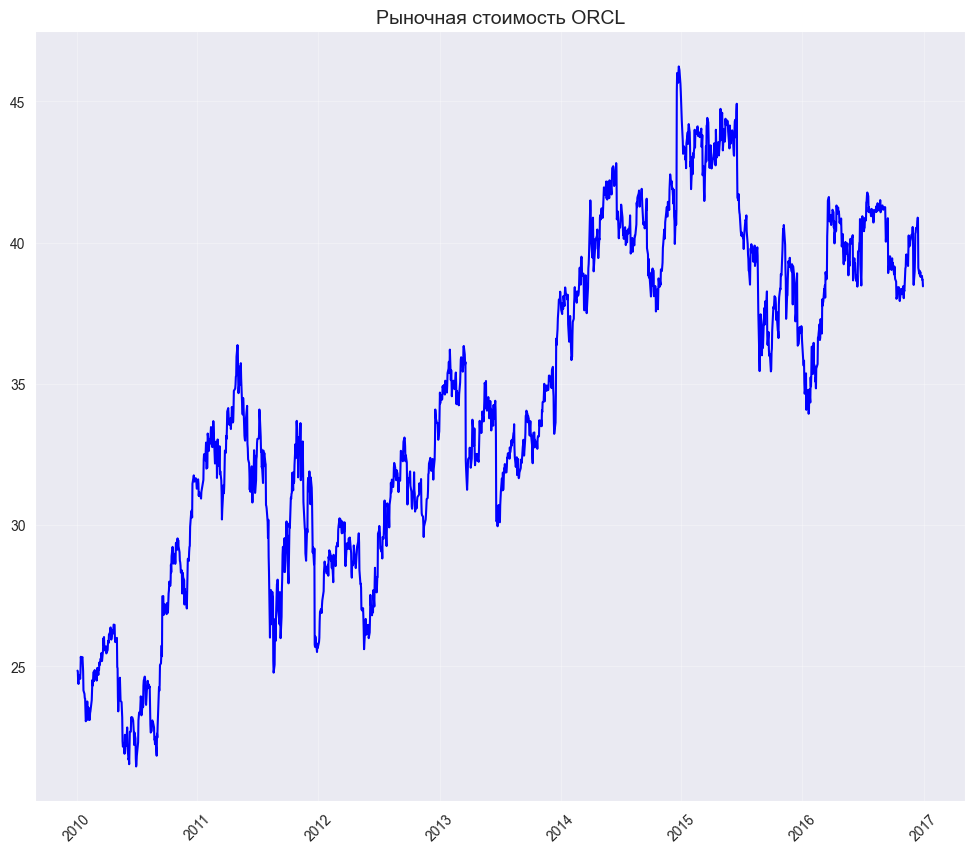

In [8]:
show_stock_price(oracle, symbol)

# Подготовка данных.

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [10]:
# Нормализуем данные.
scaler = MinMaxScaler(feature_range=(0, 1))
oracle['close'] = scaler.fit_transform(oracle['close'].values.reshape(-1, 1))

In [11]:
# Разбиение на выборки.
test_size = 0.2
split_index = int(oracle.shape[0] * (1 - test_size))
df_train, df_test = oracle.iloc[:split_index], oracle.iloc[split_index:]
print(df_train.tail(5))
df_test.head(5)

           date       open     close        low       high      volume
1404 2015-08-03  39.950001  0.736778  39.459999  40.009998  12444500.0
1405 2015-08-04  39.590000  0.734760  39.529999  40.000000   9697300.0
1406 2015-08-05  39.900002  0.733952  39.630001  40.020000  11982000.0
1407 2015-08-06  39.630001  0.721034  39.150002  39.840000  10613000.0
1408 2015-08-07  39.360001  0.730723  39.230000  39.689999  10655100.0


,date,open,close,low,high,volume
1409,2015-08-10,39.759998,0.744045,39.700001,40.049999,9525800.0
1410,2015-08-11,39.529999,0.714978,39.020000,39.680000,10600500.0
1411,2015-08-12,38.740002,0.719419,38.500000,39.360001,11062300.0
1412,2015-08-13,39.220001,0.720630,38.990002,39.560001,7785700.0
1413,2015-08-14,39.330002,0.724667,39.180000,39.500000,7185000.0


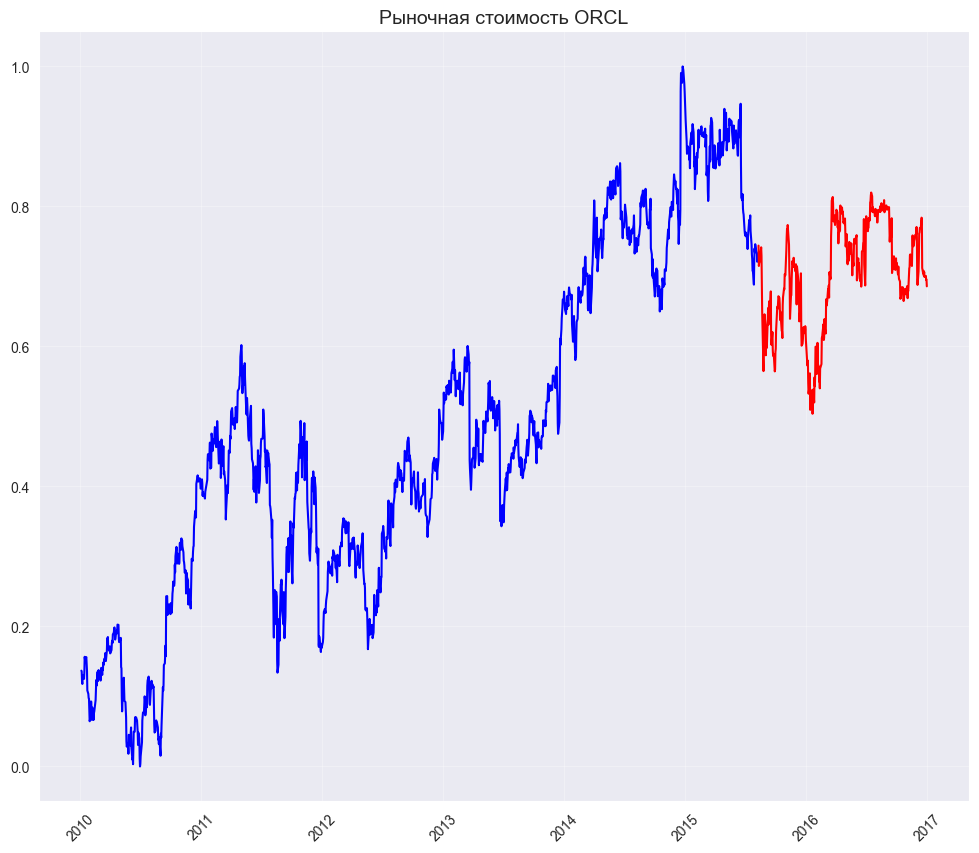

In [12]:
# Отобразим нормализованный, разбитый на выборки датасет.
show_stock_price(df_train, symbol, df_test)

In [56]:
# Разобъем датасет на последовательности.
window_size = 30

train_data = df_train['close'].values
test_data = df_test['close'].values

x, y = [], []
for i in range(len(train_data) - window_size):
    x.append(train_data[i:i + window_size])
    y.append(train_data[i + window_size])
x = np.array(x)
y = np.array(y)

x_val, y_val = [], []
for i in range(len(test_data) - window_size):
    x_val.append(test_data[i:i + window_size])
    y_val.append(test_data[i + window_size])
x_val = np.array(x_val)
y_val = np.array(y_val)

(323, 30) (323,)


In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, shuffle=False)

# Модель.

In [76]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.metrics import mean_absolute_error

In [66]:
model = Sequential()

model.add(Input(shape=(window_size, 1)))

model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [94]:
checkpoint_path = BASE_PATH + '/model.keras'
checkpoint = ModelCheckpoint(
    checkpoint_path, monitor='loss', 
    save_best_only=True, mode='min', verbose=1
)

early_stopping = EarlyStopping(
    monitor='loss', min_delta=0,
    patience=20, verbose=1
)

tensorboard = TensorBoard(log_dir='./logs')

history = model.fit(
    x_train, y_train,
    epochs=300,
    batch_size=32,
    verbose=1,
    callbacks=[checkpoint, early_stopping, tensorboard]
)

Epoch 1/300
32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7336e-04
Epoch 1: loss improved from inf to 0.00054, saving model to D:\Development\university\course03\llm\practice03/content/nyse/model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8027e-04
Epoch 2/300
31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.9478e-04
Epoch 2: loss did not improve from 0.00054
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.9506e-04
Epoch 3/300
31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.6088e-04
Epoch 3: loss did not improve from 0.00054
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.6069e-04
Epoch 4/300
30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.2735e-04
Epoch 4: loss did not improve from 0.00054
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.3210e-04
Epoch 5/300
29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.6098e-04
Epoch 5: loss improved from 0.00054 to 0.00053, saving model to D:\Development\university\course03\llm\practice03/content/nyse/model.keras
35/35 ━━━━━━━━━

In [96]:
best_model = load_model(checkpoint_path)
best_model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,705 (479.32 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 81,804 (319.55 KB)

In [97]:
# Предсказание.
predictions = best_model.predict(x_val)

# Отмена нормализации.
predictions = scaler.inverse_transform(predictions)
real_values = scaler.inverse_transform(y_val.reshape(-1, 1))
print('Predicted:', *predictions[:6], predictions.shape)
print('     Real:', *real_values[:6], real_values.shape)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted: [36.99888] [36.248528] [36.01895] [36.1257] [36.09218] [35.454994] (323, 1)
     Real: [36.189999] [35.990002] [36.060001] [36.049999] [35.439999] [35.509998] (323, 1)


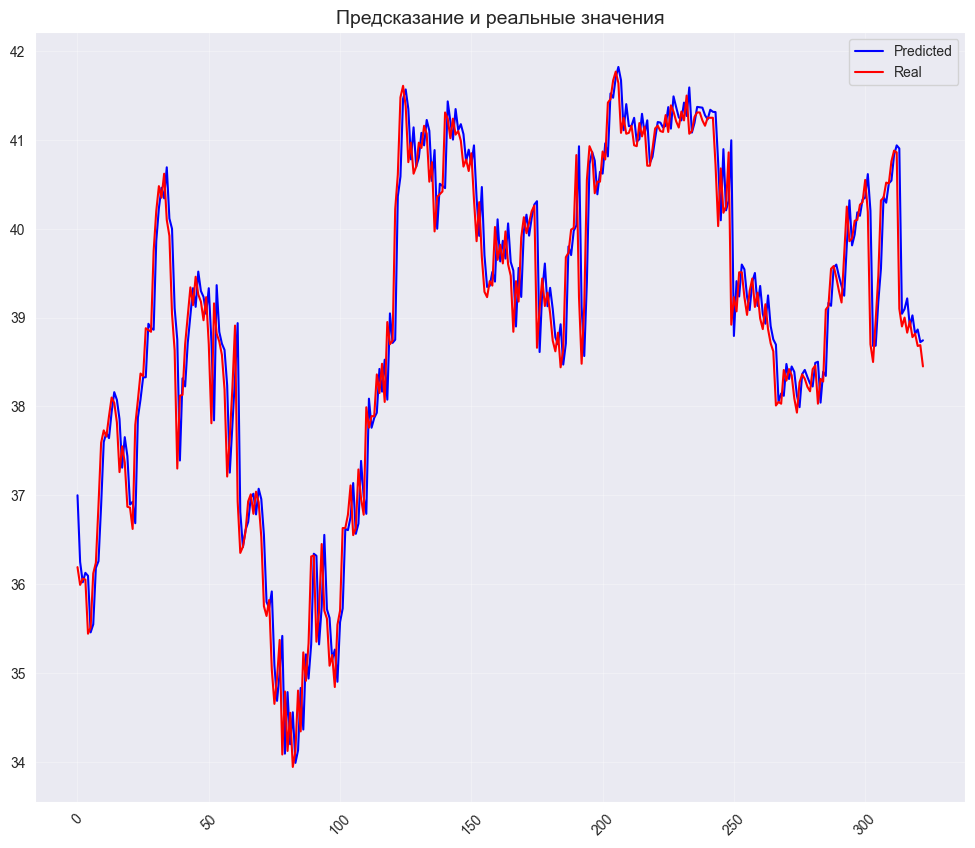

In [104]:
fig, ax = plt.subplots(1, figsize=(12, 10))
ax.plot(predictions, label='Predicted', color='blue')
ax.plot(real_values, label='Real', color='red')
plt.grid(alpha=0.3)
plt.xticks(rotation=45)

plt.title(f'Предсказание и реальные значения', fontsize=14)
plt.legend()

plt.show()

In [99]:
print(f'Validation MAE: {mean_absolute_error(real_values, predictions):.2f}')

Validation MAE: 0.35


In [100]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [102]:
%tensorboard --logdir ./logs